### import libraries

In [1]:
import folium
import ee
import matplotlib.pyplot as plt
import seaborn as sns
import IPython.display as disp
from branca.element import Figure
import numpy as np

<a id="2"></a>
## 2. Area of interest:Watershed

<font size="3">  
    



#### Lets briefly view the region using Folium

In [2]:
fig1 = Figure(width=550,height=350)

map1 = folium.Map(location=[10.609601137591667,77.614637405216],zoom_start=12, width=550,height=350);
fig1.add_child(map1)
# lets mark land on the map
folium.Marker(location=[10.609601137591667,77.614637405216],popup='Default popup Marker1',tooltip='Click here to see Popup').add_to(map1)
display(fig1)

#### Mark the Area of Interest (AOI)

<font size="3">
    
Here I draw a polygon of Berambadi watershed region using GeoJSON file.
I copied the GeoJSON file by marking the AOI by hand in the website: [https://geojson.io/](http://)
Here I am marking an area surrouding the Berambadi watershed region arbitaririly in the above link and copy the coordinate geoJSON file below:

In [3]:
watershed1={
  "type": "FeatureCollection",
  "features": [
    {
      "type": "Feature",
      "properties": {},
      "geometry": {
        "coordinates": [
          77.614637405216,
          10.609601137591667
        ],
        "type": "Point"
      }
    },
    {
      "type": "Feature",
      "properties": {},
      "geometry": {
        "coordinates": [
          [
            77.60794824555512,
            10.617271206833692
          ],
          [
            77.60834199661184,
            10.617234053872991
          ],
          [
            77.60829789649301,
            10.616868716188947
          ],
          [
            77.60788524538748,
            10.61691206136048
          ],
          [
            77.60794509554779,
            10.617271206833692
          ]
        ],
        "type": "LineString"
      }
    }
  ]
}

In [4]:
folium.GeoJson(data=watershed1,style_function=lambda x: {'fillColor': 'yellow'}).add_to(map1);
display(fig1)

<a id="2"></a>
## 3. Google Earth Initialization

In [6]:
ee.Authenticate()

In [7]:
ee.Initialize(project='ee-balagavrish2004')

In [8]:
coords = watershed1['features'][0]['geometry']['coordinates']
aoi = ee.Geometry.Polygon(coords)

<a id="4"></a>
## 4. Sentinel-1 Imagery

#### Available polarization on the region

In [9]:
# Instead of taking coordinates of the point geometry, take the coordinates of the LineString geometry:
coords = watershed1['features'][1]['geometry']['coordinates']
aoi = ee.Geometry.Polygon(coords)

#### Visualizing VH backscatter on area of interest

In [ ]:
'''url = image.select('VV').getThumbURL({'min': -20, 'max': 0})
disp.Image(url=url, width=800)'''

"url = image.select('VV').getThumbURL({'min': -20, 'max': 0})\ndisp.Image(url=url, width=800)"

In [10]:
# Define a method for displaying Earth Engine image tiles to folium map.
def add_ee_layer(self, ee_image_object, vis_params, name):
  map_id_dict = ee.Image(ee_image_object).getMapId(vis_params)
  folium.raster_layers.TileLayer(
    tiles = map_id_dict['tile_fetcher'].url_format,
    attr = 'Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
    name = name,
    overlay = True,
    control = True
  ).add_to(self)

# Add EE drawing method to folium.
folium.Map.add_ee_layer = add_ee_layer

#### Visualizing VV backscatter on the map of Folium

In [11]:
# Instead of taking coordinates of the point geometry, take the coordinates of the LineString geometry:
coords = watershed1['features'][1]['geometry']['coordinates']  # Access the LineString geometry

# Ensure the LineString is closed by adding the first point to the end if necessary
if coords[0] != coords[-1]:
    coords.append(coords[0])

# Check if there are at least 3 distinct points
if len(coords) < 3:
    raise ValueError("The LineString must have at least 3 distinct points to create a polygon.")

aoi = ee.Geometry.Polygon(coords)  # Create a polygon using these coordinates

# Create the map object.
fig2 = Figure(width=550,height=550)

# Assuming you want to visualize data within 'aoi':
# Example:
sentinel1 = ee.ImageCollection('COPERNICUS/S1_GRD').filterBounds(aoi).first()  # Get an image
image = sentinel1.select('VV')  # Select the band

# Visualize the image
map2 = folium.Map(location=[10.609601137591667,77.614637405216],zoom_start=13, width=550,height=350);
fig2.add_child(map2)

# Add the S1 rgb composite to the map object.
map2.add_ee_layer(image,{'min': -20, 'max': 0}, 'FFA')

# Display the map.
display(map2)

<a id="5"></a>
## 5. NDVI from Sentinel-2 Imagery

<font size="3">
We will plot NDVI using sentinel-2 data

In [14]:
img_coll = ee.ImageCollection('COPERNICUS/S2_SR')
# Define the date range
date_range = ee.DateRange('2023-01-01', '2023-12-31')

img_coll = img_coll.filterBounds(aoi).filterDate(date_range)

# Get the first image from the filtered collection
img = img_coll.first()

# Define the red and NIR bands
red = ee.Image(img.select('B4'))
nir = ee.Image(img.select('B8'))

# Calculate NDVI
ndvi = (nir.subtract(red)).divide(nir.add(red))

In [13]:
# Visualize the NDVI image on a map using Folium
ndvi_vis = {'min': -1, 'max': 1, 'palette': ['#00ff00', '#ffff00', '#ff0000']}
# Create the map object.
fig3 = Figure(width=550,height=550)
map3 = folium.Map(location=[10.609601137591667,77.614637405216],zoom_start=11, width=550,height=350);
fig3.add_child(map3)

# Add the S1 rgb composite to the map object.
map3.add_ee_layer(ndvi,ndvi_vis, 'FFA')
# Display the map.
display(map3)

<a id="7"></a>
## 7. Backscatter time series

In [19]:
# Define the location of interest (bounding box of 10km radius)
location = ee.Geometry.Point(77.614637405216, 10.609601137591667).buffer(10000).bounds()


sentinel1 = ee.ImageCollection('COPERNICUS/S1_GRD') \
      .filterBounds(location) \
      .filterDate('2022-01-01', '2025-01-31') \
      .sort('system:time_start', False) \
      .limit(5000)  # Set limit to 1000 images

# Print the number of images found
print('Number of images:', sentinel1.size().getInfo())

Number of images: 107


In [21]:
# Import the datetime module
import datetime

# Get the dates of the images in the filtered collection
dates = sentinel1.aggregate_array("system:time_start").getInfo()

# Convert the dates from Unix time to human-readable format
readable_dates = [datetime.datetime.fromtimestamp(int(d) / 1000).strftime("%Y-%m-%d") for d in dates]

print("Available dates:", readable_dates)

Available dates: ['2025-01-28', '2025-01-16', '2025-01-04', '2024-12-23', '2024-12-11', '2024-11-29', '2024-11-17', '2024-11-05', '2024-10-24', '2024-10-12', '2024-09-30', '2024-09-18', '2024-09-06', '2024-08-25', '2024-08-13', '2024-08-01', '2024-07-20', '2024-07-08', '2024-06-26', '2024-06-14', '2024-06-02', '2024-05-21', '2024-05-09', '2024-04-27', '2024-04-15', '2024-04-03', '2024-03-22', '2024-03-10', '2024-02-15', '2024-02-03', '2024-01-22', '2024-01-10', '2023-12-29', '2023-12-17', '2023-12-05', '2023-11-23', '2023-11-11', '2023-10-30', '2023-10-18', '2023-10-06', '2023-09-24', '2023-09-12', '2023-08-31', '2023-08-19', '2023-08-07', '2023-07-26', '2023-07-14', '2023-07-02', '2023-06-20', '2023-06-08', '2023-05-27', '2023-05-15', '2023-05-03', '2023-04-21', '2023-04-09', '2023-03-28', '2023-03-16', '2023-03-04', '2023-02-20', '2023-02-08', '2023-01-27', '2023-01-15', '2023-01-03', '2022-12-22', '2022-12-10', '2022-11-28', '2022-11-16', '2022-11-04', '2022-10-23', '2022-10-11', '2

In [20]:
image1 = ee.Image(sentinel1.first())

value = image1.select('VV').reduceRegion(ee.Reducer.mean(), location, 30).getInfo()

value['VV']

-9.855076639649614

In [22]:
sentinel1.size().getInfo()

107

In [ ]:
images = sentinel1.toList(sentinel1.size().getInfo())
time_series = [];
# Loop through each image in the 140 images
for i in range(sentinel1.size().getInfo()):
    # Get the date of the selected image
    image = ee.Image(images.get(i))
    date = image.date().format("YYYY-MM-dd").getInfo()
    value = image.reduceRegion(ee.Reducer.mean(), location, 30).getInfo();
    time_series.append([date,value['VV'],value['VH']]);

In [ ]:
import pandas as pd
df = pd.DataFrame(time_series, columns=["date", "VV", "VH"])


In [ ]:
df

,date,VV,VH
0,2025-01-28,-9.855077,-16.950694
1,2025-01-16,-9.529319,-16.528474
2,2025-01-04,-9.502282,-16.510816
3,2024-12-23,-9.572214,-16.501568
4,2024-12-11,-9.662476,-16.892882
...,...,...,...
102,2022-02-01,-10.462990,-17.630791
103,2022-01-20,-9.729412,-16.986373
104,2022-01-20,-10.125322,-17.238117
105,2022-01-08,-9.316640,-16.595488


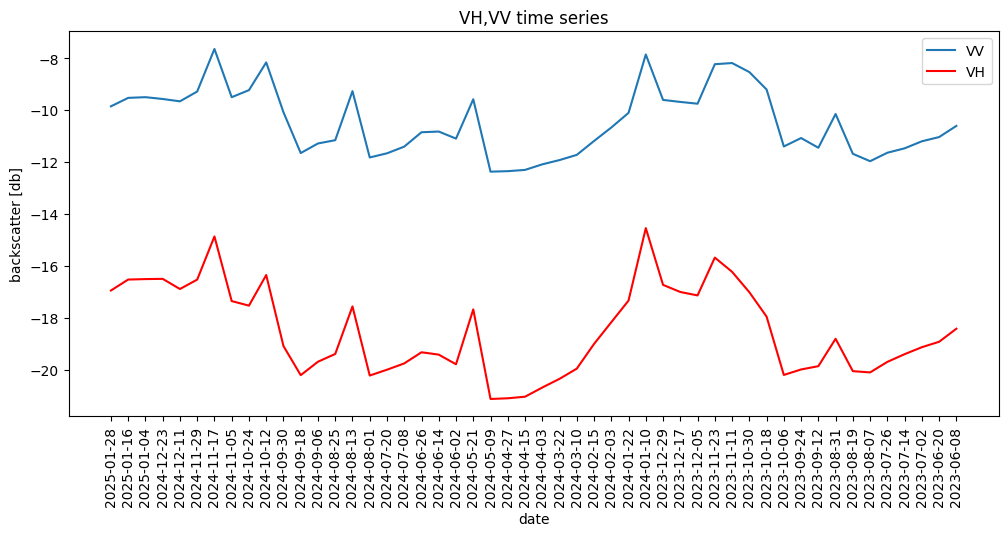

In [ ]:
fig1, ax = plt.subplots(1,1,dpi=100,figsize=(12, 5))
ax.plot(df['date'][0:50],df['VV'][0:50],label='VV');
ax.plot(df['date'][0:50],df['VH'][0:50],'r',label='VH');
ax.tick_params(axis='x', labelrotation = 90)
ax.set_title('VH,VV time series');
ax.set_xlabel('date')
ax.set_ylabel('backscatter [db]');
ax.legend()


In [ ]:
df["RVI"] = np.where((df["VV"] + df["VH"]) < 0, (4 * df["VH"]) / (df["VV"] + df["VH"]), 0)
df["Soil_Moisture"] = np.where((df["VV"] + df["VH"]) < 0, df["VH"] / (df["VV"] + df["VH"]), 0)
df["Surface_Reflectance"] = df["VV"] - df["VH"]

# Display the updated DataFrame
print(df)

           date         VV         VH       RVI  Soil_Moisture  \
0    2025-01-28  -9.855077 -16.950694  2.529410       0.632352   
1    2025-01-16  -9.529319 -16.528474  2.537202       0.634301   
2    2025-01-04  -9.502282 -16.510816  2.538847       0.634712   
3    2024-12-23  -9.572214 -16.501568  2.531519       0.632880   
4    2024-12-11  -9.662476 -16.892882  2.544553       0.636138   
..          ...        ...        ...       ...            ...   
102  2022-02-01 -10.462990 -17.630791  2.510277       0.627569   
103  2022-01-20  -9.729412 -16.986373  2.543271       0.635818   
104  2022-01-20 -10.125322 -17.238117  2.519876       0.629969   
105  2022-01-08  -9.316640 -16.595488  2.561810       0.640453   
106  2022-01-08  -9.713027 -16.915362  2.540952       0.635238   

     Surface_Reflectance  
0               7.095617  
1               6.999155  
2               7.008534  
3               6.929353  
4               7.230406  
..                   ...  
102             7.

In [ ]:
from google.colab import files

# Save DataFrame as CSV in Colab
df.to_csv("sentinel1_vegetation_indices.csv", index=False)

# Download the CSV file
files.download("sentinel1_vegetation_indices.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Sentinel2

In [ ]:
import ee
import pandas as pd


# Define a location (Example: Chennai, India)
roi = ee.Geometry.Point([77.614637405216, 10.609601137591667])

# Load Sentinel-1 Image Collection (VV, VH) and filter by date
sentinel1 = ee.ImageCollection("COPERNICUS/S1_GRD") \
    .filterBounds(roi) \
    .filterDate("2023-01-01", "2025-01-31") \
    .sort("system:time_start") \
    .limit(1000)

# Get unique Sentinel-1 image dates
s1_dates = sentinel1.aggregate_array("system:time_start").map(lambda t: ee.Date(t).format("YYYY-MM-dd")).getInfo()
s1_dates_set = set(s1_dates)  # Convert to set for quick lookup

# Load Sentinel-2 Image Collection (B2, B3, B4, etc.)
sentinel2 = ee.ImageCollection("COPERNICUS/S2_SR") \
    .filterBounds(roi) \
    .filterDate("2023-01-01", "2025-01-31") \
    .sort("system:time_start") \
    .limit(1000)

# Convert image collection to list
images = sentinel2.toList(sentinel2.size().getInfo())

# Initialize list to store results
time_series = []

# Loop through each Sentinel-2 image
for i in range(sentinel2.size().getInfo()):
    # Get the image and date
    image = ee.Image(images.get(i))
    date = image.date().format("YYYY-MM-dd").getInfo()

    # Process only if the date matches Sentinel-1 images
    if date in s1_dates_set:
        bands = image.reduceRegion(
            reducer=ee.Reducer.mean(),
            geometry=roi,
            scale=10
        ).getInfo()

        if bands:
            # Extract band values
            B2 = bands.get('B2', None)  # Blue
            B3 = bands.get('B3', None)  # Green
            B4 = bands.get('B4', None)  # Red
            B5 = bands.get('B5', None)  # Red Edge 1
            B6 = bands.get('B6', None)  # Red Edge 2
            B7 = bands.get('B7', None)  # Red Edge 3
            B8 = bands.get('B8', None)  # NIR
            B8A = bands.get('B8A', None) # NIR Narrow
            B10 = bands.get('B10', None)  # Thermal
            B11 = bands.get('B11', None)  # SWIR1
            B12 = bands.get('B12', None)  # SWIR2

            # Compute NDVI
            NDVI = (B8 - B4) / (B8 + B4) if (B8 and B4) else None

            # Compute EVI (Enhanced Vegetation Index)
            EVI = 2.5 * ((B8 - B4) / (B8 + 6 * B4 - 7.5 * B2 + 1)) if (B8 and B4 and B2) else None

            # Compute SAVI (Soil-Adjusted Vegetation Index)
            L = 0.5  # Soil brightness correction factor
            SAVI = ((B8 - B4) / (B8 + B4 + L)) * (1 + L) if (B8 and B4) else None

            # Store results
            time_series.append([
                date, B2, B3, B4, B5, B6, B7, B8, B8A, B10, B11, B12, NDVI, EVI, SAVI
            ])

# Convert to Pandas DataFrame
df1 = pd.DataFrame(time_series, columns=[
    "Date", "B2", "B3", "B4", "B5", "B6", "B7", "B8", "B8A", "B10", "B11", "B12", "NDVI", "EVI", "SAVI"
])

# Save DataFrame as CSV
df1.to_csv("Sentinel2_filtered_by_S1_dates.csv", index=False)

print("CSV saved with Sentinel-2 data matching Sentinel-1 dates!")


CSV saved with Sentinel-2 data matching Sentinel-1 dates!


In [ ]:
# Convert to Pandas DataFrame
df1 = pd.DataFrame(time_series, columns=[
    "Date", "B2", "B3", "B4", "B5", "B6", "B7", "B8", "B8A", "B10", "B11", "B12", "NDVI", "EVI", "SAVI"
])

# Save to CSV
df1.to_csv("sentinel2_vegetation_indices.csv", index=False)

print("Extracted features saved as CSV!")

Extracted features saved as CSV!


In [ ]:
df1

,Date,B2,B3,B4,B5,B6,B7,B8,B8A,B10,B11,B12,NDVI,EVI,SAVI
0,2023-01-03,1295,1531,1427,2224,3474,3820,3740,3963,None,3071,2321,0.447649,2.232195,0.671408
1,2023-03-04,1598,1846,1943,2633,3303,3528,3534,3730,None,3812,3183,0.290487,1.239869,0.435691
2,2023-05-03,4732,4432,5152,5462,5393,5440,5064,5541,None,5462,5467,-0.008614,-0.451745,-0.012920
3,2023-07-02,1637,2038,2011,3024,4137,4542,4632,4844,None,4057,3199,0.394551,1.481963,0.591781
4,2023-08-31,1604,2050,2210,2931,3631,3725,3768,4040,None,4158,3624,0.260622,0.779156,0.390901
5,2023-10-30,4716,4876,4900,5101,5650,5886,5752,6043,None,5148,4117,0.079985,-9.815668,0.119972
6,2023-12-29,17680,15776,14640,15267,13928,13275,13664,12635,None,7174,5025,-0.034483,0.078469,-0.051723
7,2024-04-27,1520,1783,1720,2709,3993,4395,4595,4675,None,3862,3002,0.455265,2.044226,0.682844
8,2024-06-26,5168,5136,5188,5079,5551,5877,6084,6066,None,4442,3519,0.079489,-1.447964,0.119228
9,2024-08-25,1734,2056,2284,2867,3611,3919,3770,4139,None,4163,3498,0.245458,0.831096,0.368156


In [ ]:
from google.colab import files

# Save DataFrame as CSV in Colab
df1.to_csv("sentinel2_vegetation_indices.csv", index=False)

# Download the CSV file
files.download("sentinel2_vegetation_indices.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<font size="3">
In conclusion, we have successfully plotted a time series of backscatter from Sentinel-1 satellite data.     